[](http://)

# Something in the wrong way, pay attention to two stadge methods!

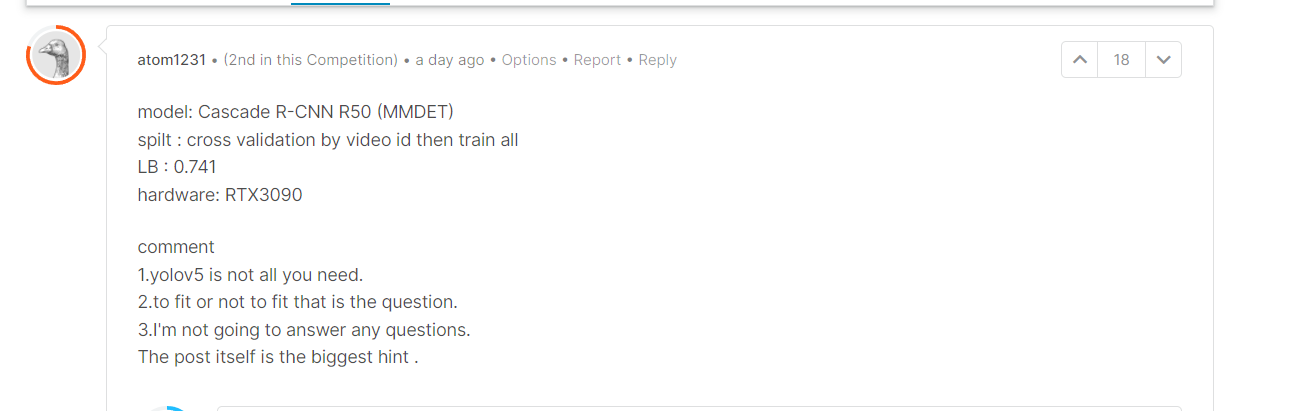

## 📒 Notebooks:
* Train: [Great-Barrier-Reef: YOLOv5 [train] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)
* Infer: [Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

# 🚩 Version Info
| Version | Model | Conf | IoU | LB  | Comment
|---|---|---|---|---|---|
| v25 | YOLOv5s | 0.15 | 0.50 | 0.453 |  |
| v30 | YOLOv5s | 0.19 | 0.45 | 0.433 | tta |


# 🛠 Install Libraries

In [ ]:
# bbox-utility, check https://github.com/awsaf49/bbox for source code
!pip install -q /kaggle/input/loguru-lib-ds/loguru-0.5.3-py3-none-any.whl
!pip install -q /kaggle/input/bbox-lib-ds

# 📚 Import Libraries

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')
import torch
from PIL import Image

# 📌 Key-Points
* One have to submit prediction using the provided **python time-series API**, which makes this competition different from previous Object Detection Competitions.
* Each prediction row needs to include all bounding boxes for the image. Submission is format seems also **COCO** which means `[x_min, y_min, width, height]`
* Copmetition metric `F2` tolerates some false positives(FP) in order to ensure very few starfish are missed. Which means tackling **false negatives(FN)** is more important than false positives(FP). 
$$F2 = 5 \cdot \frac{precision \cdot recall}{4\cdot precision + recall}$$

## Please Upvote if you find this Helpful

# 📖 Meta Data
* `train_images/` - Folder containing training set photos of the form `video_{video_id}/{video_frame}.jpg`.

* `[train/test].csv` - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

* `video_id` - ID number of the video the image was part of. The video ids are not meaningfully ordered.
* `video_frame` - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.
* `sequence` - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
* `sequence_frame` - The frame number within a given sequence.
* `image_id` - ID code for the image, in the format `{video_id}-{video_frame}`
* `annotations` - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate `(x_min, y_min)` of its lower left corner within the image together with its `width` and `height` in pixels --> (COCO format).

###### ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'
# CKPT_DIR  = '/kaggle/input/greatbarrierreef-yolov5-train-ds'
CKPT_PATH = '/kaggle/input/leonv5inferv5s60/best.pt' # by @steamedsheep
IMG_SIZE  = 6400
CONF      = 0.30
IOU       = 0.50
AUGMENT   = True

In [ ]:
# Train Data
df = pd.read_csv(f'/kaggle/input/tensorflow-great-barrier-reef/train.csv')
df['image_path'] = f'/kaggle/input/tensorflow-great-barrier-reef/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

## Number of BBoxes

In [ ]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

# 🔨 Helper

In [ ]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo, voc2coco
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

# 📦 [YOLOv5](https://github.com/ultralytics/yolov5/)
<img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/splash.jpg" width=800>

In [ ]:
!mkdir -p /root/.config/Ultralytics
!cp /kaggle/input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

In [ ]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('/kaggle/input/yolov5-lib-ds',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

# 🔭 Inference

## Helper

In [ ]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

## Run Inference on **Train**

In [ ]:
CKPT_PATH = '../input/yolov5s6/f2_sub2.pt'
CONF = 0.30
IOU = 0.50
IMG_SIZE = 6400
AUGMENT = False

In [ ]:
pwd

In [ ]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
image_paths = df[df.num_bbox>1].sample(100).image_path.tolist()
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)[...,::-1]
    bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    display(show_img(img, bboxes, bbox_format='coco'))
    if idx>5:
        break

## Init `Env`

In [ ]:
import greatbarrierreef
env = greatbarrierreef.make_env()# initialize the environment
iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission

In [ ]:
iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission

## Run Inference on **Test**

In [ ]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, confs  = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    annot          = format_prediction(bboxes, confs)
    pred_df['annotations'] = annot
    env.predict(pred_df)
    if idx<3:
        display(show_img(img, bboxes, bbox_format='coco'))

# 👀 Check Submission

In [ ]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()

## Please Upvote if you find this Helpful

<div align="center"> <img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png" width=600>